# InceptionV3 Transfer Learning and Model training

In [1]:
import boto3, re
from sagemaker import get_execution_role
role = get_execution_role()

In [2]:
import tensorflow
print(tensorflow.__version__)


1.15.2


In [3]:
!pip install pydicom

You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
!pip install mlxtend  

You should consider upgrading via the 'pip install --upgrade pip' command.


# Import dependencies

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras.utils import Sequence
import math
import pydicom
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
import seaborn as sns
from pydicom import dcmread
from pydicom.filebase import DicomBytesIO
import cv2
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import time

Using TensorFlow backend.


In [7]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

# **Load Labels**

In [8]:
root_path = 'sagemaker-capstone-pd'
train_dicom_dir = 'pneumonia-dataset/stage_2_train_images/'
train_lables_filename = 'pneumonia-dataset/stage_2_train_labels.csv'


In [9]:
def load_csv_file(path, filename):
  bucket = path
  data_key = filename
  data_location = 's3://{}/{}'.format(bucket, data_key) 
  train_labels_df = pd.read_csv(data_location)
  return train_labels_df

In [10]:
training_data = load_csv_file(root_path,train_lables_filename )

In [11]:
print(training_data.shape)

(30227, 6)


In [12]:
training_data.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [13]:
training_imgs = ["{}.dcm".format(x) for x in list(training_data.patientId)]

In [14]:
print(training_imgs[:5])

['0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', '00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm', '00322d4d-1c29-4943-afc9-b6754be640eb.dcm', '003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm', '00436515-870c-4b36-a041-de91049b9ab4.dcm']


In [15]:
training_labels_1 = list(training_data['Target'])

In [16]:
print(training_labels_1[:5])

[0, 0, 0, 0, 1]


In [17]:
training_data_1 = pd.DataFrame( {'Images': training_imgs,'Target': training_labels_1})


In [18]:
training_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
Images    30227 non-null object
Target    30227 non-null int64
dtypes: int64(1), object(1)
memory usage: 472.4+ KB


In [19]:
training_data_1.head()

,Images,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm,0
2,00322d4d-1c29-4943-afc9-b6754be640eb.dcm,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm,0
4,00436515-870c-4b36-a041-de91049b9ab4.dcm,1


# Train & Validation split

In [21]:
from sklearn.model_selection import train_test_split

# Sort the rows of dataframe by column 'Images'
training_data_1 = training_data_1.sort_values(by ='Images', ascending=True )
#temp_df = training_data_1.iloc[:100] use only for testing
temp_df = training_data_1
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 28988
Data columns (total 2 columns):
Images    30227 non-null object
Target    30227 non-null int64
dtypes: int64(1), object(1)
memory usage: 708.4+ KB


In [22]:
training_set = pd.DataFrame()
validation_set = pd.DataFrame()

training_set, validation_set = train_test_split(temp_df, random_state = 0, test_size = 0.2)

In [23]:
training_set.reset_index(inplace = True)
validation_set.reset_index(inplace = True)

print(training_set.info())
print(validation_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24181 entries, 0 to 24180
Data columns (total 3 columns):
index     24181 non-null int64
Images    24181 non-null object
Target    24181 non-null int64
dtypes: int64(2), object(1)
memory usage: 566.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
index     6046 non-null int64
Images    6046 non-null object
Target    6046 non-null int64
dtypes: int64(2), object(1)
memory usage: 141.8+ KB
None


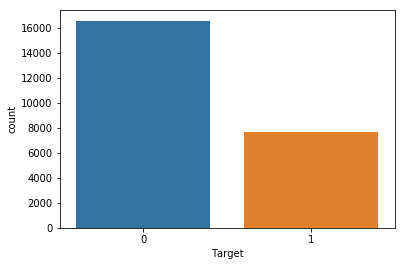

In [24]:
ax = sns.countplot(x="Target", data=training_set)

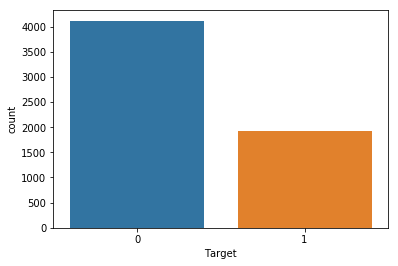

In [25]:
ax = sns.countplot(x="Target", data=validation_set)

In [26]:
training_set.head()

,index,Images,Target
0,5846,4a21a2af-8822-43aa-9dcd-6b412dcb3d43.dcm,0
1,27577,f4d92d38-4a58-45d4-a5a3-dd83772e51bc.dcm,0
2,22291,c9b3c7ce-4f39-4702-8206-2903d27afa9c.dcm,0
3,16384,9ea49ec4-2b4f-4e7b-94f1-99ba8d10a629.dcm,0
4,10849,7245635f-de15-4117-9069-e39743d9da2f.dcm,0


In [27]:
IMAGE_SIZE = 224
BATCH_SIZE = 50
EPOCHS = 5 # Number of epochs.
PATIENCE = 2 # Patience for early stopping
MULTI_PROCESSING = True 
THREADS = 1
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [28]:
# Training Data Generator

class DataGen(Sequence):
    def __init__(self, data_df):
        self.paths = []
        df_len = len(data_df)
        self.pneumonia_calss = np.zeros((df_len,2))
        for index, row in data_df.iterrows():
          #print(index)
          path = row['Images']
          classes = row['Target']
          self.paths.append(path) # Read image from here
          #self.pneumonia_calss.append(classes) # Read target from here
          if classes == 1:
            self.pneumonia_calss[index, 0] = 1
            self.pneumonia_calss[index, 1] = 0
          else:
            self.pneumonia_calss[index, 0] = 0
            self.pneumonia_calss[index, 1] = 1
        

    def __len__(self):
        return math.ceil(len(self.pneumonia_calss) / BATCH_SIZE)

    def __getitem__(self, idx): # Get a batch
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image path
        batch_coords = self.pneumonia_calss[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image coords

        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        session = boto3.Session()
        s3_session = session.client('s3')
        for i, f in enumerate(batch_paths):
            
            f = train_dicom_dir +  f
            #print('file for loading ',  f)
            fileobj = s3_session.get_object(Bucket=root_path,  Key=f )
            dicom_data = fileobj['Body'].read()
            dicom_bytes = DicomBytesIO(dicom_data)
            c_dicom = dcmread(dicom_bytes) 
            image = c_dicom.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3: 
                img = np.stack((image,) * 3, -1)
 
            dim = (IMAGE_SIZE, IMAGE_SIZE)
            img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
            #print(' File ', f, ' img shape ', img.shape )
            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
            #print('batch_coords' , batch_coords)
            
        return batch_images, batch_coords

In [29]:
train_dataGen  = DataGen(training_set)
validation_datagen = DataGen(validation_set)

# Model Initialization

In [30]:
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Trianable Layers

In [31]:
base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = False

for layer in base_model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f7cec7732e8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7cec782550> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f7cec72b0f0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f7cec6dc0f0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7cec6cafd0> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f7cec68fd30> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f7cec6a4b00> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7cec6b0dd8> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f7cec64e630> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f7cec65d518> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f7cec64eb00> False
<tensorflow.python.keras.layers.convolutio

In [32]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [33]:
model = tf.keras.Sequential([
                          base_model,
                          keras.layers.GlobalAveragePooling2D(),
                          keras.layers.Dense(2, activation='sigmoid')])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [33]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy']) # binary classification

model_file = "inceptionv3_tl_mt_model-{val_acc:.2f}.h5"
checkpoint = ModelCheckpoint(model_file, monitor="val_acc", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_acc", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_acc", factor=0.2, patience=PATIENCE, min_lr=0.0001, verbose=1, mode="max")

time_callback = TimeHistory()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Model Training

In [34]:
history = model.fit_generator(generator=train_dataGen,
                    epochs=EPOCHS,
                    callbacks=[checkpoint, reduce_lr, stop,time_callback],
                    workers=THREADS,
                    shuffle=True,
                    validation_data = validation_datagen,
                    verbose=1)

Epoch 1/5
121/484 [======>.......................] - ETA: 20:39 - loss: 0.5802 - acc: 0.7228
Epoch 00001: val_acc improved from -inf to 0.72279, saving model to inceptionv3_tl_mt_model-0.72.h5
484/484 [==============================] - 2088s 4s/step - loss: 0.4991 - acc: 0.7510 - val_loss: 0.5802 - val_acc: 0.7228
Epoch 2/5
121/484 [======>.......................] - ETA: 21:06 - loss: 0.8765 - acc: 0.6852
Epoch 00002: val_acc did not improve from 0.72279
484/484 [==============================] - 2092s 4s/step - loss: 0.4645 - acc: 0.7762 - val_loss: 0.8765 - val_acc: 0.6852
Epoch 3/5
121/484 [======>.......................] - ETA: 21:31 - loss: 0.7490 - acc: 0.6918
Epoch 00003: val_acc did not improve from 0.72279

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
484/484 [==============================] - 2150s 4s/step - loss: 0.4538 - acc: 0.7824 - val_loss: 0.7490 - val_acc: 0.6918


In [35]:
print(time_callback.times)

[2088.3682038784027, 2092.206821203232, 2149.999055624008]


# **Display accuracy & loss**

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

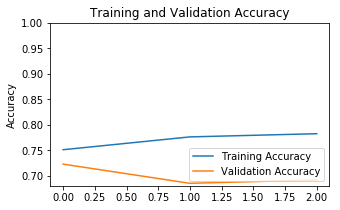

In [37]:
plt.figure(figsize=(5, 3))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()

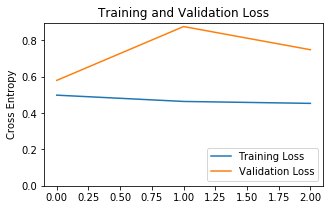

In [38]:
plt.figure(figsize=(5, 3))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

# **Prediction**
load weights

In [35]:
model.load_weights('/home/ec2-user/SageMaker/inceptionv3_tl_mt_model-0.72.h5') #change if required

In [36]:
session = boto3.Session()
s3_session = session.client('s3')

In [37]:
def getTestImage(filename):
  #print('filename ', filename)
  f = train_dicom_dir +  filename
    
  fileobj = s3_session.get_object(Bucket=root_path,  Key=f )
  dicom_data = fileobj['Body'].read()
  dicom_bytes = DicomBytesIO(dicom_data)
  c_dicom = dcmread(dicom_bytes) 
            
  
  image = c_dicom.pixel_array
  # If grayscale. Convert to RGB for consistency.
  if len(image.shape) != 3 or image.shape[2] != 3: 
    img = np.stack((image,) * 3, -1)
 
  dim = (IMAGE_SIZE, IMAGE_SIZE)
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
            
  #print(' File ', f, ' img shape ', img.shape )
  img = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  return img

In [38]:
test_set = pd.DataFrame()
test_set = training_data_1.sort_values(by ='Images', ascending=False )
test_set = test_set.iloc[:3000]
test_set.reset_index(inplace= True)
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
index     3000 non-null int64
Images    3000 non-null object
Target    3000 non-null int64
dtypes: int64(2), object(1)
memory usage: 70.4+ KB


In [39]:
def predict_test(test_data_df): 

      cm_df = pd.DataFrame(columns = ['patientId', 'y_true', 'y_pred']) 
      #print ('Info ' , test_data_df.info()) 
      threshold = 0.4

      
      for ind in test_data_df.index: 
        f = test_data_df['Images'][ind]
        y_true = test_data_df['Target'][ind]
        #print ('f ', f , ' y_true ', 'y_true')
        img = getTestImage(f)
        img = np.expand_dims(img, axis=0) 
            
        results = model.predict(img)
        #print('results ', results)
        if results[0][0] >= threshold:
          y_pred = 1
        else:
          y_pred = 0
        #print ( ' patient ' , f , ' y_true ', y_true , ' y_pred ' , y_pred, ' results ', results )
        cm_df = cm_df.append ({'patientId': f, 'y_true' : y_true , 'y_pred' : y_pred}, ignore_index=True)
      return cm_df

In [40]:
cm_df = predict_test(test_set)

# Confusion Matrix

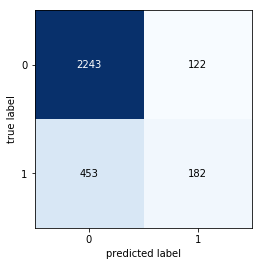

In [41]:
y_true = cm_df['y_true'].to_list()
y_pred = cm_df['y_pred'].to_list()

CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(4, 4))

plt.show()

# Metrics

In [46]:
from sklearn.metrics import classification_report

In [47]:
print(classification_report(y_true, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      2365
           1       0.60      0.29      0.39       635

    accuracy                           0.81      3000
   macro avg       0.72      0.62      0.64      3000
weighted avg       0.78      0.81      0.78      3000

